In [1]:
import os
from typing import List, Tuple
import wfdb
from wfdb import processing
from tqdm import tqdm
import numpy as np


def clean_annotations(annotation: wfdb.Annotation) -> Tuple[List[int], List[str]]:
    """
    Remove anotações vazias da lista de anotações.

    Args:
        annotation (wfdb.Annotation): Anotação contendo as amostras e notas auxiliares.

    Returns:
        Tuple[List[int], List[str]]: Listas de amostras e notas auxiliares não vazias.
    """
    sample, aux_note = annotation.sample, annotation.aux_note
    non_empty_indices = [i for i, note in enumerate(aux_note) if note != ""]
    clean_aux_note = [aux_note[i] for i in non_empty_indices]
    clean_sample = [sample[i] for i in non_empty_indices]
    return clean_sample, clean_aux_note

def get_ranges_afib(record_path: str, signal_len: int) -> List[Tuple[int, int]]:
    """
    Obtém os intervalos de interesse onde a anotação é AFIB.

    Args:
        record_path (str): Caminho para o registro do sinal.
        signal_len (int): Comprimento total do sinal.

    Returns:
        List[Tuple[int, int]]: Lista de tuplas com os intervalos de início e fim onde a anotação é AFIB.
    """
    annotation = wfdb.rdann(record_path, "atr")
    sample, aux_note = clean_annotations(annotation)
    ranges_interest = []

    for i, label in enumerate(aux_note):
        if label == "(AFIB":
            afib_start = sample[i]
            afib_end = signal_len if i == len(sample) - 1 else sample[i + 1] - 1
            ranges_interest.append((afib_start, afib_end))

    return ranges_interest


In [2]:
def process_records(database_path: str) -> None:
    """
    Processa todos os registros no caminho especificado, excluindo os registros indesejados.

    Args:
        database_path (str): Caminho para o diretório contendo os registros.
    """
    # Carregar os IDs dos registros
    record_ids = []
    with open(os.path.join(database_path, "RECORDS")) as f:
        record_ids = [line.strip() for line in f.readlines()]

    # Remover registros indesejados da base AFDB
    record_ids.remove("00735")
    record_ids.remove("03665")

    # Processar cada registro
    for record_index, record_id in enumerate(record_ids):
        record_path = os.path.join(database_path, record_id)
        _, ecg_metadata = wfdb.rdsamp(record_path)
        signal_len = ecg_metadata["sig_len"]
        
        # Gravação completa
        recording = wfdb.rdrecord(record_name=record_path)

        extract_intervals = get_ranges_afib(record_path, signal_len)
        
        # Para teste, processa apenas o primeiro registro
        print(f"Record ID: {record_id}, AFIB Intervals: {extract_intervals}")

        # Quantidade de RRIs em cada segmento do sinal ECG
        SEGMENT_SIZE = 5 
        
        stack_rr = np.empty((0, SEGMENT_SIZE), dtype=int)
        stack_recording = []
        
        # Percorre cada trecho diagnosticado com AFIB
        for start_index, end_index in tqdm(extract_intervals):
            annotations_r_peaks = wfdb.rdann(
                record_path,
                sampfrom=start_index,
                sampto=end_index,
                extension="qrs",
            )
            positions_r_peaks = annotations_r_peaks.sample
            frequency = annotations_r_peaks.fs
            
            positions_r_peak_ms = (positions_r_peaks / frequency) * 1000
            
            rr_intervals = processing.calc_rr(positions_r_peak_ms, fs=frequency)
            
            num_segments = (len(positions_r_peaks) - 1) // SEGMENT_SIZE

            if num_segments <= 0:
                continue

            last_segment = num_segments * SEGMENT_SIZE

            for i in range(0, last_segment, SEGMENT_SIZE):
                # Montando a saída dos segmentos (RRIs)
                rr_segment = rr_intervals[i : i + SEGMENT_SIZE]
                stack_rr = np.vstack((stack_rr, rr_segment))

                # Montando a saída dos segmentos (Gravação 2 derivações)
                start_index = positions_r_peaks[i]
                end_index = positions_r_peaks[i + SEGMENT_SIZE]
                rec_seg = recording.p_signal[start_index:end_index]
                stack_recording.append(rec_seg)
        
        destination_results = 'exploring_afdb_results'

        if not os.path.exists(destination_results):
            os.makedirs(destination_results)
        
        np.save(
            file=f"./exploring_afdb_results/{record_index}_{record_id}_rri_segment", arr=stack_rr
        )

        stack_recording = np.array(stack_recording, dtype=object)
        
        np.save(
            file=f"./exploring_afdb_results/{record_index}_{record_id}_recording_segment",
            arr=stack_recording,
        )
        
        # # Esse break serve para rodar apenas para a primeira gravação (Teste)
        # break

DATABASE_PATH = "/home/apo-pc/Documents/GitHub/atrial_fibrilation_detection/data/mit-bih-atrial-fibrillation-database-1/files"
process_records(DATABASE_PATH)

Record ID: 04015, AFIB Intervals: [(102584, 119603), (121773, 122193), (133348, 166856), (1096245, 1098053), (1135296, 1139594), (1422436, 1423547), (1459277, 1460415)]


100%|██████████| 7/7 [00:00<00:00, 39.68it/s]


Record ID: 04043, AFIB Intervals: [(266498, 376327), (2585284, 2602515), (2634911, 2739811), (2745162, 2779580), (2834739, 2841727), (3119235, 3121705), (3324526, 3352182), (3607124, 3637518), (3665624, 3680629), (3690356, 3707031), (3714455, 3729453), (3757893, 3850172), (3864338, 3882085), (3911965, 3939728), (3947348, 3992718), (4002976, 4067052), (4100718, 4135454), (4144613, 4180312), (4184151, 4207222), (4216965, 4232560), (4397189, 4429651), (4469008, 4475225), (4484786, 4508434), (4527258, 4551867), (4572558, 4602708), (4627077, 4636997), (4650429, 4700107), (4846373, 4859019), (4977503, 5001898), (5025436, 5047414), (5064396, 5076308), (5093223, 5105439), (5122383, 5136041), (5143706, 5152530), (5223157, 5237639), (5245920, 5258588), (5269137, 5310429), (5328717, 5383210), (5412443, 5446748), (5481762, 5504397), (5518464, 5535881), (5559927, 5576036), (5592280, 5633071), (5668367, 5685491), (5713187, 5719860), (5746977, 5774761), (5797297, 5822968), (5859230, 5866171), (589168

100%|██████████| 82/82 [00:16<00:00,  4.87it/s]


Record ID: 04048, AFIB Intervals: [(556677, 580970), (716110, 724075), (2148473, 2153996), (2998791, 3003177), (3638922, 3677437), (4157977, 4162993), (7681741, 7686230)]


100%|██████████| 7/7 [00:00<00:00, 12.91it/s]


Record ID: 04126, AFIB Intervals: [(11388, 138151), (171592, 191327), (252786, 322907), (748262, 847440), (7832273, 7836541), (8273014, 8291854), (8307657, 8313238)]


100%|██████████| 7/7 [00:00<00:00, 10.14it/s]


Record ID: 04746, AFIB Intervals: [(1097510, 1098683), (2284261, 2285671), (2319586, 2326153), (2608376, 5696114), (5705521, 7496880)]


100%|██████████| 5/5 [00:00<00:00,  9.36it/s]


Record ID: 04908, AFIB Intervals: [(1227217, 1329238), (1744908, 1945250), (3399665, 3562784), (3565302, 3579130), (3583635, 3619439), (3674940, 3719452), (3720336, 3724942), (8591413, 8797786)]


100%|██████████| 8/8 [00:01<00:00,  7.38it/s]


Record ID: 04936, AFIB Intervals: [(413691, 447760), (1023430, 1027875), (1091766, 1105883), (1115502, 1151701), (1174135, 1189342), (1203805, 1204430), (1205494, 1316328), (1333475, 1352711), (1364357, 1382499), (1393567, 1406690), (1430321, 1668403), (1694048, 1890995), (1904539, 1905744), (1936943, 2047169), (2068111, 2102387), (2119395, 2138827), (2147935, 2280888), (2303975, 2464066), (2494806, 2498352), (2506461, 3130657), (3165666, 4753216), (4781740, 4792438), (4804448, 4901633), (4917777, 5080722), (5100410, 5110360), (5118731, 5523272), (5548092, 5687292), (5724606, 5953275), (5981405, 5984043), (5990301, 5992458), (5995465, 7325786), (7366279, 7453004), (7490747, 7582420), (7609874, 7612043), (7619457, 8269227), (8311034, 8358030)]


100%|██████████| 36/36 [00:03<00:00,  9.46it/s]


Record ID: 05091, AFIB Intervals: [(1633050, 1633998), (1900120, 1901524), (2270154, 2270586), (2574098, 2575189), (2591265, 2593949), (2618884, 2619972), (2877400, 2880800), (4350349, 4360986)]


100%|██████████| 8/8 [00:00<00:00, 18.23it/s]


Record ID: 05121, AFIB Intervals: [(1843491, 1844114), (1849414, 2305444), (2316258, 2416868), (2424776, 3435781), (3448070, 3676803), (3683982, 3729924), (3844733, 3889215), (3897888, 4899445), (4908291, 6917104), (6924329, 7099842), (7106612, 7118119), (7126125, 7322624), (7327125, 7448749), (7453750, 7519624), (7528250, 7795999), (7802000, 7818874), (7825750, 7832124), (7836000, 7841874), (7845375, 7856249), (7875875, 7901534)]


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Record ID: 05261, AFIB Intervals: [(2162708, 2163555), (4057942, 4062019), (4387405, 4400368), (5497141, 5500960), (5586022, 5587001), (5593100, 5596161), (5707701, 5712200), (5764404, 5766059), (6484710, 6567194), (6598300, 6602554), (7405319, 7406543)]


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]


Record ID: 06426, AFIB Intervals: [(37, 526602), (534235, 556303), (580089, 1141938), (1171384, 1237710), (1260913, 1269655), (1279294, 1306071), (1321073, 1861731), (1883236, 1884275), (1958340, 1969008), (1973372, 1983160), (1989878, 2025146), (2037856, 2311117), (2325600, 2339126), (2351379, 2356313), (2376449, 2394948), (2403427, 2422235), (2436612, 2595565), (2613266, 2808841), (2831335, 3041404), (3054861, 3208996), (3218947, 4067638), (4072555, 4097665), (4108663, 4307772), (4317264, 6143602), (6173823, 6178528), (6188862, 9205760)]


100%|██████████| 26/26 [00:02<00:00, 10.97it/s]


Record ID: 06453, AFIB Intervals: [(763937, 767746), (926994, 934173), (1046206, 1063040), (1603835, 1605896), (7326248, 7364038), (7457733, 7482874)]


100%|██████████| 6/6 [00:00<00:00, 13.66it/s]


Record ID: 06995, AFIB Intervals: [(7, 1381606), (1383575, 1387964), (1389204, 1399237), (1856046, 1864113), (3789346, 3793221), (6274349, 9205760)]


100%|██████████| 6/6 [00:00<00:00,  9.58it/s]


Record ID: 07162, AFIB Intervals: [(174, 9205760)]


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Record ID: 07859, AFIB Intervals: [(43, 9205760)]


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Record ID: 07879, AFIB Intervals: [(1783080, 7333066), (7334783, 7335467)]


100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


Record ID: 07910, AFIB Intervals: [(806384, 864892), (1758668, 1760362), (1881846, 2322141), (2556411, 2558624), (8241169, 9205760)]


100%|██████████| 5/5 [00:00<00:00, 13.90it/s]


Record ID: 08215, AFIB Intervals: [(1774708, 3204434), (3216995, 9205760)]


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


Record ID: 08219, AFIB Intervals: [(3077924, 3126812), (3144896, 3236449), (3272405, 3373025), (3385696, 3491432), (3534149, 3593002), (3603735, 3664615), (3679789, 3813869), (3824127, 3841688), (3854499, 3873942), (4433500, 4537194), (4544500, 4569749), (4581494, 4668720), (4676269, 4708990), (4717972, 4736917), (4742277, 4778242), (4788054, 4806611), (4818981, 4863751), (4873479, 4900295), (4911280, 4928795), (4941994, 4966820), (4980705, 5012328), (5020409, 5067425), (5074252, 5083416), (5091007, 5105316), (5116801, 5157999), (5170948, 5189836), (5203078, 5308513), (5319425, 5370404), (5404332, 5469499), (5478103, 5504767), (5513587, 5579082), (5583855, 5649864), (5657428, 5676703), (5685322, 5742740), (5751408, 5757245), (5759472, 5818652), (5832312, 6025441), (6040285, 6065974), (6075963, 6086764)]


100%|██████████| 39/39 [00:06<00:00,  5.80it/s]


Record ID: 08378, AFIB Intervals: [(742007, 2281341), (4602354, 4868965), (4877160, 4963328), (4977273, 4988715), (4995131, 5016173)]


100%|██████████| 5/5 [00:00<00:00,  7.45it/s]


Record ID: 08405, AFIB Intervals: [(2545096, 2549498), (2562781, 9205760)]


100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


Record ID: 08434, AFIB Intervals: [(2237188, 2315412), (2321489, 2489166), (2496786, 2606816)]


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Record ID: 08455, AFIB Intervals: [(2808396, 2820742), (2850351, 9205760)]


100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


In [3]:
# Trechos da gravação 04015 particionadas em segmentos de 5 RRIs que foram diagnosticadas com FA

A = np.load(f"./exploring_afdb_results/0_04015_recording_segment.npy", allow_pickle=True)

In [14]:
A

(100,)

In [12]:
A_0 = A[0]

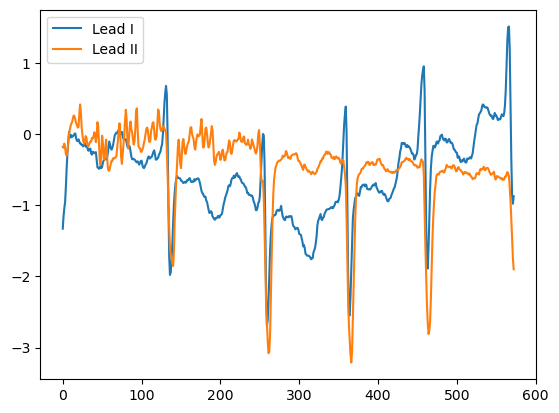

In [23]:
# Plot A_0
import matplotlib.pyplot as plt

plt.plot(A_0[:, 0])
plt.plot(A_0[:, 1])
plt.legend(["Lead I", "Lead II"])
plt.show()

In [11]:
# Os RRIs da gravação 04015 agrupados em segmentos de tamanho 5 diagnosticados com FA

np.load(f"./exploring_afdb_results/0_04015_rri_segment.npy", allow_pickle=True)

array([[552., 492., 416., 396., 436.],
       [532., 568., 424., 296., 384.],
       [328., 364., 388., 360., 296.],
       [340., 376., 364., 372., 492.],
       [428., 572., 448., 632., 472.],
       [464., 420., 392., 400., 484.],
       [428., 316., 652., 508., 356.],
       [440., 500., 384., 520., 448.],
       [372., 492., 424., 572., 524.],
       [364., 428., 392., 288., 628.],
       [504., 528., 504., 528., 472.],
       [348., 448., 524., 404., 476.],
       [460., 516., 432., 460., 416.],
       [492., 544., 456., 320., 316.],
       [428., 536., 500., 380., 372.],
       [472., 440., 300., 384., 448.],
       [424., 352., 420., 396., 380.],
       [416., 388., 376., 348., 328.],
       [356., 376., 460., 560., 392.],
       [304., 380., 488., 452., 556.],
       [396., 368., 704., 680., 684.],
       [860., 468., 444., 452., 316.],
       [328., 436., 452., 384., 312.],
       [608., 564., 428., 528., 396.],
       [344., 404., 392., 324., 428.],
       [672., 500., 332.,